<a href="https://colab.research.google.com/github/jajapuramshivasai/iquhack_2025/blob/main/Shor15_sucess_%5B3_07%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See how to use Shor's algorithm to factor 15 here:    <b><a href="https://portal.quantumrings.com/doc/Shors.html">Shor15</a></b>

<i><b>Source code to factorize 15</b></i>

Note: Be sure to use your API token and your account name.

Step 1. Import the required modules and obtain the backend

In [1]:
!pip install QuantumRingsLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.8 MB/s eta 0:00:00


In [2]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math

provider = QuantumRingsProvider(token ='rings-200.ClLnaB7LhHsuphvAbGRIa1to7KDTMGzt', name='shiva_sj@ph.iitr.ac.in')
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

{'name': 'shiva_sj@ph.iitr.ac.in',
 'token': 'rings-200.ClLnaB7LhHsuphvAbGRIa1to7KDTMGzt',
 'max_qubits': '200'}

Step 2. Define the core methods

In [3]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return






# STAR

In [4]:
#my addition

#classical functions

def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

"""Function that calculates the array of angles to be used in the addition in Fourier Space"""
def getAngles(a,N):
    s=bin(int(a))[2:].zfill(N)
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=pow(2, -(j-i))
        angles[N-i-1]*=np.pi
    return angles





In [5]:
def swap_registers(circuit, reg, n):
	for i in range(n//2):
		circuit.swap(reg[i], reg[n-i-1])


# applies qft to first n qubits of reg
def qft(circuit, reg, n, swaps):
	for j in range(n):
		circuit.h(reg[n-j-1])
		for m in range(n-j-1):
			circuit.cu1(np.pi/float(2**(n-j-1-m)), reg[m], reg[n-j-1])

	if(swaps):
		swap_registers(circuit, reg, n)

# applies inverse qft to first n qubits of reg
def qft_dagger(circuit, reg, n, swaps):
	if(swaps):
		swap_registers(circuit, reg, n)

	for j in range(n):
		for m in range(j):
			circuit.cu1(-np.pi/float(2**(j-m)), reg[m], reg[j])
		circuit.h(reg[j])

In [9]:
#quantum functions

"""Creation of a doubly controlled phase gate"""
def ccphase(circuit,angle,ctl1,ctl2,tgt):
    circuit.cu1(angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu1(-angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    circuit.cu1(angle/2,ctl2,tgt)

"""Creation of the circuit that performs addition by a in Fourier Space"""
"""Can also be used for subtraction by setting the parameter inv to a value different from 0"""
def phiADD(circuit,q,a,N,inv):
    angle=getAngles(a,N)
    for i in range(0,N):
        if inv==0:
            circuit.u1(angle[i],q[i])
        else:
            circuit.u1(-angle[i],q[i])

"""Single controlled version of the phiADD circuit"""
def cphiADD(circuit,q,ctl,a,n,inv):
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            circuit.cu1(angle[i],ctl,q[i])
        else:
            circuit.cu1(-angle[i],ctl,q[i])

"""Doubly controlled version of the phiADD circuit"""
def ccphiADD(circuit,q,ctl1,ctl2,a,n,inv):
    angle=getAngles(a,n)
    for i in range(0,n):
        if inv==0:
            ccphase(circuit,angle[i],ctl1,ctl2,q[i])
        else:
            ccphase(circuit,-angle[i],ctl1,ctl2,q[i])

"""Circuit that implements doubly controlled modular addition by a"""
def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    phiADD(circuit, q, N, n, 1)
    qft_dagger(circuit, q, n, 0)
    circuit.cx(q[n-1],aux)
    qft(circuit,q,n,0)
    cphiADD(circuit, q, aux, N, n, 0)

    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    qft_dagger(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1], aux)
    circuit.x(q[n-1])
    qft(circuit,q,n,0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)

"""Circuit that implements the inverse of doubly controlled modular addition by a"""
def ccphiADDmodN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    qft_dagger(circuit, q, n, 0)
    circuit.x(q[n-1])
    circuit.cx(q[n-1],aux)
    circuit.x(q[n-1])
    qft(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    qft_dagger(circuit, q, n, 0)
    circuit.cx(q[n-1], aux)
    qft(circuit, q, n, 0)
    phiADD(circuit, q, N, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)

"""Circuit that implements single controlled modular multiplication by a"""
def cMULTmodN(circuit, ctl, q, aux, a, N, n):
    qft(circuit,aux,n+1,0)
    for i in range(0, n):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[n+1], (2**i)*a % N, N, n+1)
    qft_dagger(circuit, aux, n+1, 0)

    for i in range(0, n):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, N)
    qft(circuit, aux, n+1, 0)
    i = n-1
    while i >= 0:
        ccphiADDmodN_inv(circuit, aux, q[i], ctl, aux[n+1], pow(2,i)*a_inv % N, N, n+1)
        i -= 1
    qft_dagger(circuit, aux, n+1, 0)


# calculate period of f(x)=a^x mod N
def periodFinding(N, a):
	# n = np.ceil(np.log(N, 2))
	n = int(np.ceil(np.log2(N)))
	if(n<4):
		n=4
	m = 2*n

	qregUp 		= QuantumRegister(m)
	qregDown 	= QuantumRegister(n)
	aux 		= QuantumRegister(n+2)
	creg 		= ClassicalRegister(m)

	qc = QuantumCircuit(qregUp, qregDown, aux, creg)

	qft(qc, qregUp, m, 1)
	qc.x(qregDown[0])

	for i in range(0, m):
		cMULTmodN(qc, qregUp[i], qregDown, aux, int(pow(a, pow(2, i))), N, n)

	qft_dagger(qc, qregUp, m, 1)
	qc.measure(qregUp, creg)


	shots = 1024
	job = backend.run(qc, shots=shots)
	counts = job.result().get_counts(qc)

	### process data start
	i=0
	avg = 0
	while i < len(counts):
		val = list(counts.values())[i]
		output_desired = list(counts.keys())[i]
		x_value = int(output_desired, 2)
		print("value:{0} \t times:{1}".format(x_value, val))

		avg += (val*val)/shots

		i += 1

	i=0
	Variance = 0
	while i < len(counts):
		val = list(counts.values())[i]

		Variance += (((val-avg)**2)*val)/shots

		i += 1

	stdDev = np.sqrt(Variance)
	treshold = avg - stdDev

	if(stdDev<avg*0.3):
		treshold = 0

	print("---------------------------")
	print("avg     : {0}".format(avg))
	print("stdDev  : {0}".format(stdDev))
	print("treshold: {0}".format(treshold))
	print("---------------------------")
	### process data end

	i=0
	MOverR = 2**m
	while i < len(counts):
		val = list(counts.values())[i]
		if(val<treshold):
			i+=1
			continue
		output_desired = list(counts.keys())[i]
		x_value = int(output_desired, 2)

		print("value:{0} \t times:{1}".format(x_value, val))

		if(x_value<MOverR and x_value!=0):
			MOverR = x_value

		i+=1;

	print("---------------------------")
	return np.floor(((2**m)/MOverR)+0.5) #contFrac(MOverR, m)

def gcd(a, b):
	if(b==0):
		return a
	else:
		return gcd(b, a%b)

# select a random number a
def Step1(N):
	a = random.randint(2, N-1)
	print("Selected a: {0}".format(a))

	gcdAN = gcd(a,N)
	if(gcdAN!=1):
		p = gcdAN
		q = N/gcdAN
		return (p, q)
	else:
		return (a, 0)

# find the period and check if it satisfies the conditions
def Step2(N, a):
	print("executing the quantum circuit...")
	r = periodFinding(N, a)
	print("found r:{0}".format(r))
	if(r%2==1):
		return 0
	else:
		if((a**(r/2)+1)%N==0):
			print("a**(r/2)+1) mod N = 0")
			return 0
		else:
			return r


def MyShor(N):
	r = 0
	a = 0
	p = 0
	q = 0
	while(True):
		print("-----------Step1--------------")
		(p,q) = Step1(N)
		if(q!=0):
			print("Lucky selection for a")
			return (p,q)
		else:
			a = p
			print("-----------Step2--------------")
			r = Step2(N,a)
			if(r!=0):
				p = gcd((a**(r/2)-1),N)
				q = gcd((a**(r/2)+1),N)
				break

			print("\n+++++++++++++++++++++++++++++++++++++++++++++\n")

	return (p,q)

In [7]:
import random

In [ ]:
p,q = MyShor(3127)
print(p,q)
# print(q)

-----------Step1--------------
Selected a: 1901
-----------Step2--------------
executing the quantum circuit...


# END


Step 3. Perform the algorithm

In [ ]:
# Shor’s algorithm to factorize 15 using 7^x mod 15.
numberofqubits = 7
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(3 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(6)
qc.barrier()

# Modular exponentiation 7^x mod 15
qc.cx(q[2],q[4] )
qc.cx(q[2],q[5] )
qc.cx(q[6],q[4] )
qc.ccx(q[1],q[5],q[3] )
qc.cx(q[3],q[5] )
qc.ccx(q[1],q[4],q[6] )
qc.cx(q[6],q[4] ) #
qc.barrier()

# IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 3)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# Draw the circuit
qc.draw('mpl')

       ┌───┐ ╎                                     ╎ ┌───┐               »
q[0]: ■┤ H ├─╎─────────────────────────────────────╎─┤ H ├───────■───────»
       ├───┤ ╎                                     ╎ └───┘┌──────┴──────┐»
q[1]: ■┤ H ├─╎──────────────────■─────────■────────╎──────┤ U1(-pi/2)   ├»
       ├───┤ ╎                  │         │        ╎      └─────────────┘»
q[2]: ■┤ H ├─╎───■────■─────────│─────────│────────╎─────────────────────»
       └───┘ ╎   │    │       ┌─┴─┐       │        ╎                     »
q[3]: ■──────╎───│────│───────┤ X ├──■────│────────╎─────────────────────»
             ╎ ┌─┴─┐  │  ┌───┐└─┬─┘  │    │  ┌───┐ ╎                     »
q[4]: ■──────╎─┤ X ├──│──┤ X ├──│────│────■──┤ X ├─╎─────────────────────»
             ╎ └───┘┌─┴─┐└─┬─┘  │  ┌─┴─┐  │  └─┬─┘ ╎                     »
q[5]: ■──────╎──────┤ X ├──│────■──┤ X ├──│────│───╎─────────────────────»
       ┌───┐ ╎      └───┘  │       └───┘┌─┴─┐  │   ╎                     »
q[6]: ■┤ X ├─╎───────────

The circuit to factor 15 shown above.

Job Running
Job Done.
Ending Job Monitor


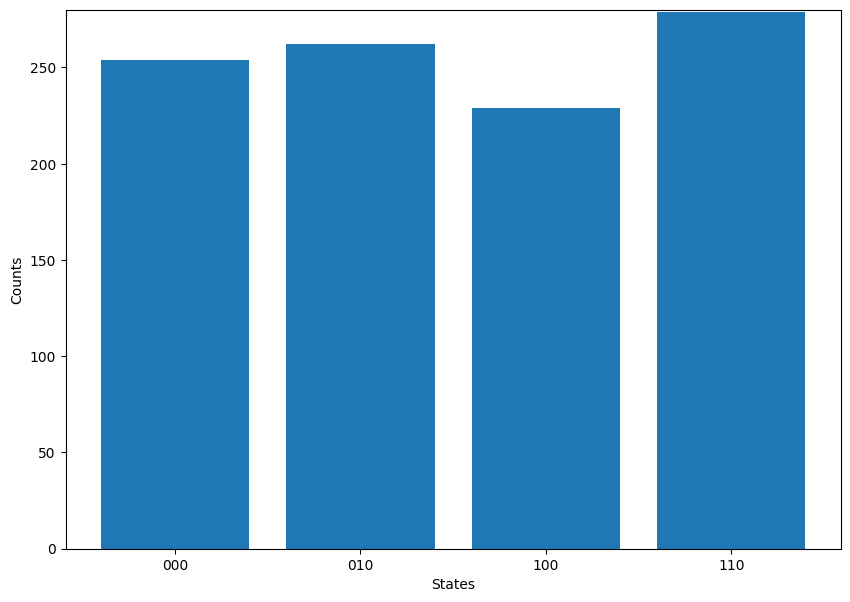

In [ ]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

# visualize
plot_histogram(counts)

#clean up
del q, c, qc
del result
del job

A plot of the execution results is shown above. Compare this with the calculated values.

we got r = 6
a = 7


Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers